# End-to-end demand forecasting workflow

Author: Andrii Kruchko

Version Date: 01/19/2023

[DataRobot's API reference documentation](https://docs.datarobot.com/en/docs/api/reference/index.html)

## Summary

This notebook illustrates an end-to-end demand forecasting workflow in DataRobot.  Time series forecasting in DataRobot has a huge suite of tools and approaches to handle highly complex multiseries problems. These include:

- Automatic feature engineering and creation of lagged variables across multiple data types, as well as training dataset creation
- Diverse approaches for time series modeling with text data, learning from cross-series interactions, and scaling to hundreds or thousands of series
- Feature generation from an uploaded calendar of events file specific to your business or use case
- Automatic backtesting controls for regular and irregular time series
- Training dataset creation for an irregular series via custom aggregations
- Segmented modeling, hierarchical clustering for multi-series  models, text support, and ensembling
- Periodicity and stationarity detection and automatic feature list creation with various differencing strategies
- Cold start modeling on series with limited or no history
- Insights for models

This notebook serves as an introduction to that diverse functionality via the Python SDK. Subsequent notebooks in this series will dig deeper into the nuance of seeing data drift in production, handling cold-start series, and deploying a web-based application for what-if analysis for promotion planning. As such, this notebook provides a framework to inspect and handle common data and modeling challenges, identifying common pitfalls in real-life time series data, and leaving it to the reader to dig deeper on specific issues. The dataset consists of 50 skus across many stores over a 2 year period with varying series history, typical of a business releasing and removing products over time.

DataRobot will be used for the model training, selection, deployment, and making predictions.  Snowflake will work as a datasource for both training and testing, and as a storage to write predictions back. This workflow, however, applies to any data source, e.g. Redshift, S3, Big Query, Synapse, etc.  For examples of data loading from other environemnts, check out the other end-to-end examples in this Git Repo. 

The following steps are covered:

- [Ingesting the data from Snowflake into AI Catalog within DataRobot](#data_prep)
- [Running a new DataRobot project](#modeling)
- [Getting the insights from the top model](#insights)
- [Deploying the recommended model](#deployment)
- [Defining and running a job to make predictions and write them back into Snowflake](#preds)



## Setup

### Optional: Import public demo data

For this workflow, you can download publicly available datasets (training, scoring, and calendar data) from DataRobot's S3 bucket to your database or load into your DataRobot instance. 

If you are using Snowflake, you will need to update the fields below with your Snowflake information. Data will be loaded and created in your Snowflake instance. You will also need the following files found in the same repo as this notebook:

* dr_utils.py
* datasets.yaml

Once you are done with this notebook, remember to delete the data from your Snowflake instance.

In [1]:
# requires Python 3.8 or higher
from dr_utils import prepare_demo_tables_in_db

Fill out the credentials for your Snowflake instance. You will need write access to a database.

In [2]:
db_user = "your_username"  # Username to access Snowflake database
db_password = "your_password"  # Password
account = "account"  # Snowflake account identifier
db = "YOUR_DB_NAME"  # Database to Write_To
warehouse = "YOUR_WAREHOUSE"  # Warehouse
schema = "YOUR_SCHEMA"  # Schema

Use the util function to pull the data from DataRobot's public S3 and import into your Snowflake instance.

In [3]:
response = prepare_demo_tables_in_db(
    db_user=db_user,
    db_password=db_password,
    account=account,
    db=db,
    warehouse=warehouse,
    schema=schema,
)

******************************
table: ts_demand_forecasting_train


,STORE_SKU,DATE,UNITS,UNITS_MIN,UNITS_MAX,UNITS_MEAN,UNITS_STD,TRANSACTIONS_SUM,PROMO_MAX,PRICE_MEAN,STORE,SKU,SKU_CATEGORY
0,store_130_SKU_120931082,2019-05-06,388.0,44.0,69.0,55.428571,8.182443,243.0,1.0,44.8,store_130,SKU_120931082,cat_1160
1,store_130_SKU_120931082,2019-05-13,318.0,37.0,62.0,45.428571,8.079958,210.0,1.0,44.8,store_130,SKU_120931082,cat_1160
2,store_130_SKU_120931082,2019-05-20,126.0,13.0,23.0,18.000000,3.915780,118.0,0.0,44.8,store_130,SKU_120931082,cat_1160
3,store_130_SKU_120931082,2019-05-27,285.0,23.0,65.0,40.714286,14.067863,197.0,1.0,44.8,store_130,SKU_120931082,cat_1160
4,store_130_SKU_120931082,2019-06-03,93.0,10.0,20.0,13.285714,3.352327,87.0,0.0,44.8,store_130,SKU_120931082,cat_1160


info for  ts_demand_forecasting_train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8589 entries, 0 to 8588
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   STORE_SKU         8589 non-null   object 
 1   DATE              8589 non-null   object 
 2   UNITS             8589 non-null   float64
 3   UNITS_MIN         8589 non-null   float64
 4   UNITS_MAX         8589 non-null   float64
 5   UNITS_MEAN        8589 non-null   float64
 6   UNITS_STD         8589 non-null   float64
 7   TRANSACTIONS_SUM  8589 non-null   float64
 8   PROMO_MAX         8589 non-null   float64
 9   PRICE_MEAN        8589 non-null   float64
 10  STORE             8589 non-null   object 
 11  SKU               8589 non-null   object 
 12  SKU_CATEGORY      8589 non-null   object 
dtypes: float64(8), object(5)
memory usage: 872.4+ KB
None
writing ts_demand_forecasting_train to snowflake from:  https://s3.amazonaws.com/datarobot_

,STORE_SKU,DATE,UNITS,UNITS_MIN,UNITS_MAX,UNITS_MEAN,UNITS_STD,TRANSACTIONS_SUM,PROMO_MAX,PRICE_MEAN,STORE,SKU,SKU_CATEGORY
0,store_130_SKU_120931082,2022-07-04,70.0,7.0,13.0,10.000000,2.581989,65.0,0.0,22.8,store_130,SKU_120931082,cat_1160
1,store_130_SKU_120931082,2022-07-11,89.0,5.0,19.0,12.714286,5.936168,84.0,0.0,22.8,store_130,SKU_120931082,cat_1160
2,store_130_SKU_120931082,2022-07-18,90.0,10.0,18.0,12.857143,3.132016,85.0,0.0,22.8,store_130,SKU_120931082,cat_1160
3,store_130_SKU_120931082,2022-07-25,77.0,4.0,20.0,11.000000,5.000000,67.0,0.0,22.8,store_130,SKU_120931082,cat_1160
4,store_130_SKU_120931082,2022-08-01,85.0,6.0,26.0,12.142857,6.466028,82.0,0.0,22.8,store_130,SKU_120931082,cat_1160


info for  ts_demand_forecasting_scoring
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   STORE_SKU         1050 non-null   object 
 1   DATE              1050 non-null   object 
 2   UNITS             850 non-null    float64
 3   UNITS_MIN         850 non-null    float64
 4   UNITS_MAX         850 non-null    float64
 5   UNITS_MEAN        850 non-null    float64
 6   UNITS_STD         850 non-null    float64
 7   TRANSACTIONS_SUM  850 non-null    float64
 8   PROMO_MAX         1050 non-null   float64
 9   PRICE_MEAN        850 non-null    float64
 10  STORE             1050 non-null   object 
 11  SKU               1050 non-null   object 
 12  SKU_CATEGORY      1050 non-null   object 
dtypes: float64(8), object(5)
memory usage: 106.8+ KB
None
writing ts_demand_forecasting_scoring to snowflake from:  https://s3.amazonaws.com/dataro

,date,event_type
0,2017-01-01,New Year's Day
1,2017-01-02,New Year's Day (Observed)
2,2017-01-16,"Martin Luther King, Jr. Day"
3,2017-02-20,Washington's Birthday
4,2017-05-29,Memorial Day


info for  ts_demand_forecasting_calendar
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        81 non-null     object
 1   event_type  81 non-null     object
dtypes: object(2)
memory usage: 1.4+ KB
None
writing ts_demand_forecasting_calendar to snowflake from:  https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/ts_demand_forecasting_calendar.csv


### Import libraries

In [4]:
from datetime import datetime as dt
from platform import python_version

import datarobot as dr
import dr_utils as dru
import pandas as pd

print("Python version:", python_version())
print("Client version:", dr.__version__)

Python version: 3.9.7
Client version: 3.0.2


### Connect to DataRobot

1. In DataRobot, navigate to **Developer Tools** by clicking on the user icon in the top-right corner. From here you can generate a API Key that you will use to authenticate to DataRobot. You can find more details on creating an API key [in the DataRobot documentation](https://app.datarobot.com/docs/api/api-quickstart/index.html#create-a-datarobot-api-key). 

2. Determine your DataRobot API Endpoint. The API endpoint is the same as your DataRobot UI root. Replace {datarobot.example.com} with your deployment endpoint.

    API endpoint root: `https://{datarobot.example.com}/api/v2`
    
    For users of the AI Cloud platform, the endpoint is `https://app.datarobot.com/api/v2`
    
3. After obtaining your API Key and endpoint, there are several options to [connect to DataRobot](https://app.datarobot.com/docs/api/api-quickstart/index.html#configure-api-authentication). This notebook uses option B.

    A. Create a .yaml file and refer to it in the code:
    
        - .yaml config file example:

        ```yaml
        endpoint: 'https://{datarobot.example.com}/api/v2'
        token: 'YOUR_API_KEY'


         ```
        
        - Code to connect:
        
        ```python
        dr.Client(config_path = "~/.config/datarobot/drconfig.yaml")
        
        
        ```
        
    B. Set environment variables in the UNIX shell
    
        ```shell
        export DATAROBOT_ENDPOINT=https://{datarobot.example.com}/api/v2
        export DATAROBOT_API_TOKEN=YOUR_API_KEY
        
        
        ```
        - Code to connect:
        
        ```python
        dr.Client()
        
        
        ```
        
    C. Embed in the code
    
        ```python
        dr.Client(endpoint='https://{datarobot.example.com}/api/v2', token='YOUR_API_KEY')
        
        ```

In [5]:
# Instantiate the DataRobot connection

DATAROBOT_API_TOKEN = ""  # Get this from the Developer Tools page in the DataRobot UI
# Endpoint - This notebook uses the default endpoint for DataRobot Managed AI Cloud (US)
DATAROBOT_ENDPOINT = (
    "https://app.datarobot.com/"  # This should be the URL you use to access the DataRobot UI
)

client = dr.Client(
    token=DATAROBOT_API_TOKEN,
    endpoint=DATAROBOT_ENDPOINT,
    user_agent_suffix="AIA-E2E-TS-24",  # Optional but helps DataRobot improve this workflow
)

dr.client._global_client = client

<a id='data_prep'></a>
## Data preparation

In general, data preparation consists of several broadly defined steps:

- Explanatory data analysis
- Training data selection
- Data preparation itself based on the previous steps

Depending on the use case some of these steps can be skipped or additional business related steps may be necessary.

In this section you should define:

- The unit of analysis: every SKU sales or the whole store sales
- Observation frequency:
    - If the data is at the transaction level, you should aggregate to some regular timestamp, such as hour or day;
    - Sometimes the data provided is already aggregated, but it has a lot of missing dates. Or, from the business perspective, you may need predictions with lower resolution (e.g., weekly or monthly instead of hourly or daily).
    
The dataset should contain at least the following columns:

- Date
- Series ID: SKU, Store, Store - SKU combination
- Target

Aditionally, [the calendar file can be specified.](https://docs.datarobot.com/en/docs/modeling/time/ts-adv-modeling/ts-adv-opt.html#calendar-files)  DataRobot will automatically create features based on the calendar events (such as “days to next event” ).

### Define variables

In [6]:
date_col = "DATE"
series_id = "STORE_SKU"
target = "UNITS"

### Configure a data connection

DataRobot supports connections to a wide variety of databases through AI Catalog, allowing repeated access to the database as an AI Catalog Data Store. You can find the examples [in the DataRobot documentation](https://docs.datarobot.com/en/docs/data/connect-data/data-sources/index.html).

[Credentials for the connection to your Data Store can be securely stored within DataRobot](https://docs.datarobot.com/en/docs/data/connect-data/stored-creds.html). They will be used during the dataset creation in the AI Catalog, and can be found under the `Data Connections` tab in DataRobot.  

If you don't have credentials and a datastore created, uncomment and run the cell below.

In [ ]:
# # Find the driver ID from name
# Can be skipped if you have the ID - showing the code here for completeness
# for d in dr.DataDriver.list():
#     if d.canonical_name in 'Snowflake (3.13.9 - recommended)':
#         print((d.id, d.canonical_name))

# # Create a datastore and datastore ID
# data_store = dr.DataStore.create(data_store_type='jdbc', canonical_name='Snowflake Demo DB', driver_id='626bae0a98b54f9ba70b4122', jdbc_url= db_url)
# data_store.test(username=db_user, password=db_password)

# # Create and store credentials to allow the AI Catalog access to this database
# # These can be found in the Data Connections tab under your profile in DataRobot
# cred = dr.Credential.create_basic(name='test_cred',user=db_user, password=db_password,)

Use the snippet below to find a credential and a data connection (AKA a datastore).

In [ ]:
creds_name = "your_stored_credential"
data_store_name = "your_datastore_name"

credential_id = [cr.credential_id for cr in dr.Credential.list() if cr.name == creds_name][0]
data_store_id = [ds.id for ds in dr.DataStore.list() if ds.canonical_name == data_store_name][0]

Use the snippet below to create or get an existing data connection based on a query and upload a training dataset into the AI Catalog.

In [12]:
data_source_train, dataset_train = dru.create_dataset_from_data_source(
    data_source_name="ts_training_data",
    query=f'select * from {db}.{schema}."ts_demand_forecasting_train";',
    data_store_id=data_store_id,
    credential_id=credential_id,
)

new data source: DataSource('ts_training_data')


Use the following snippet to create or get an existing data connection based on a query and upload a calendar dataset into the AI Catalog.

In [14]:
data_source_calendar, dataset_calendar = dru.create_dataset_from_data_source(
    data_source_name="ts_calendar",
    query=f'select * from {db}.{schema}."ts_demand_forecasting_calendar";',
    data_store_id=data_store_id,
    credential_id=credential_id,
)

new data source: DataSource('ts_calendar')


The following snippet is optional and can be used to get data to investigate before modeling.

In [15]:
df = dataset_train.get_as_dataframe()
df[date_col] = pd.to_datetime(df[date_col], format="%Y-%m-%d")
print("the original data shape   :", df.shape)
print("the total number of series:", df[series_id].nunique())
print("the min date:", df[date_col].min())
print("the max date:", df[date_col].max())
df.head()

the original data shape   : (8589, 13)
the total number of series: 50
the min date: 2019-05-06 00:00:00
the max date: 2022-10-24 00:00:00


,STORE_SKU,DATE,UNITS,UNITS_MIN,UNITS_MAX,UNITS_MEAN,UNITS_STD,TRANSACTIONS_SUM,PROMO_MAX,PRICE_MEAN,STORE,SKU,SKU_CATEGORY
0,store_130_SKU_120931082,2019-05-06,388.0,44.0,69.0,55.428571,8.182443,243.0,1.0,44.8,store_130,SKU_120931082,cat_1160
1,store_130_SKU_120931082,2019-05-13,318.0,37.0,62.0,45.428571,8.079958,210.0,1.0,44.8,store_130,SKU_120931082,cat_1160
2,store_130_SKU_120931082,2019-05-20,126.0,13.0,23.0,18.000000,3.915780,118.0,0.0,44.8,store_130,SKU_120931082,cat_1160
3,store_130_SKU_120931082,2019-05-27,285.0,23.0,65.0,40.714286,14.067863,197.0,1.0,44.8,store_130,SKU_120931082,cat_1160
4,store_130_SKU_120931082,2019-06-03,93.0,10.0,20.0,13.285714,3.352327,87.0,0.0,44.8,store_130,SKU_120931082,cat_1160


<a id='eda'></a>
## EDA

Explanatory data analysis is a starting point of data preparation. The purpose of this section is to:
- check the number of series over time
- plot the target distribution and the target over time
- find out how sparse our original data is

In [16]:
# Compute per series stats to check for inconsistencies in data

df_stats = dru.make_series_stats(df, date_col, series_id, target, freq=1)

### Original frequency

It is quite common for demand forecasting use cases to have series which don't have sales any more, had temporary or seasonal sales, or were just released. The plot below shows how the number of series evolved over time for the chosen dataset.

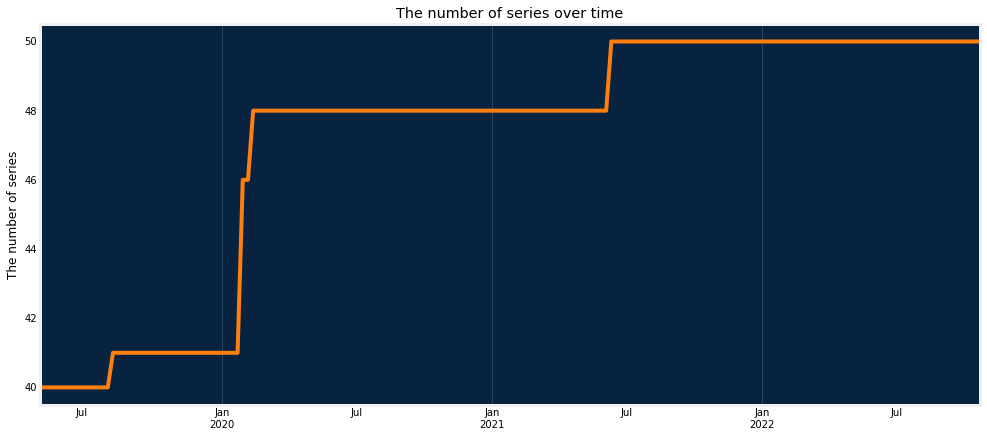

In [17]:
dru.plot_series_count_over_time(df, date_col, series_id)

The target distribution plot can help to identify the most frequent values and the shape of data in general.

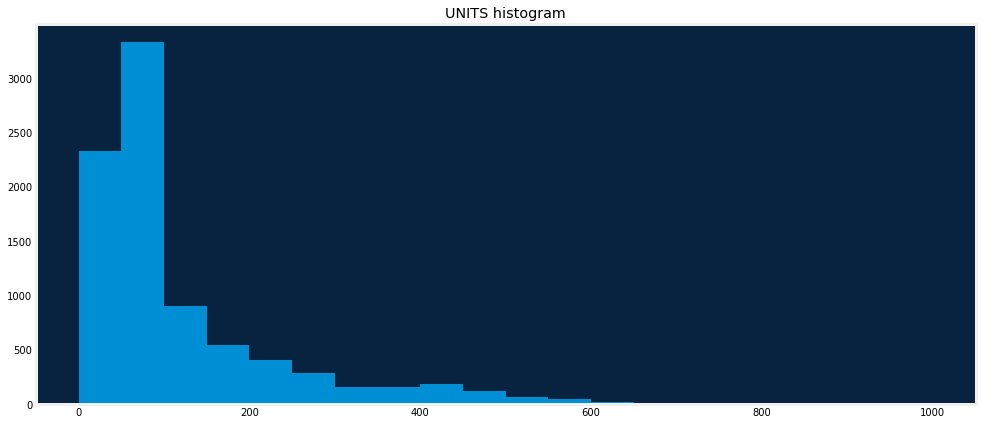

In [18]:
dru.plot_hist(df, target, clip_min=0)

The plot of the target over time can show overall seasonality, trend, /or possible issues with the data (e.g., sudden drops or periods without data).

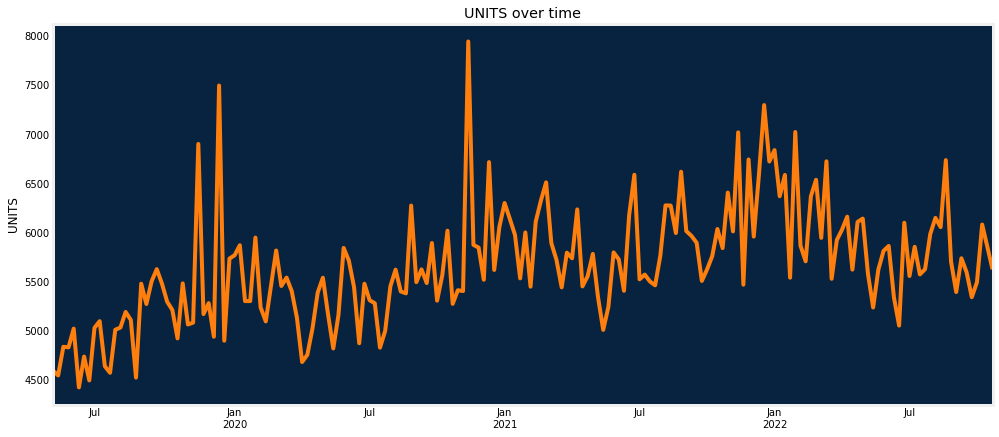

In [19]:
dru.plot_num_col_over_time(df, date_col, target, func="sum", freq="W-MON")

<a id='data_checks'></a>
### Data checks

#### Spikes

The dataset should be checked for anomalous spikes. They should be verified. If they are correct, they should be added to a calendar file, or some form of feature engineering should be completed so that the models can be able to predict these spikes.

In [20]:
df_spikes = dru.identify_spikes(df, date_col, series_id, target, span=5, threshold=7)
print("# of series with spikes:", df_spikes[df_spikes["Spike"] == 1][series_id].nunique())
df_spikes[df_spikes["Spike"] == 1].sort_values(target, ascending=False).head()

# of series with spikes: 50


,STORE_SKU,DATE,UNITS,EWA,SD,Threshold,Spike
4770,store_175_SKU_120939350,2021-08-23,657.0,596.806961,85.265846,596.860920,1
4772,store_175_SKU_120939350,2021-09-06,649.0,597.580871,76.941499,538.590492,1
4769,store_175_SKU_120939350,2021-08-16,641.0,566.710441,86.652437,606.567057,1
4782,store_175_SKU_120939350,2021-11-15,634.0,570.983367,62.093165,434.652155,1
5391,store_175_SKU_9888909,2019-08-05,628.0,541.622103,76.445072,535.115503,1


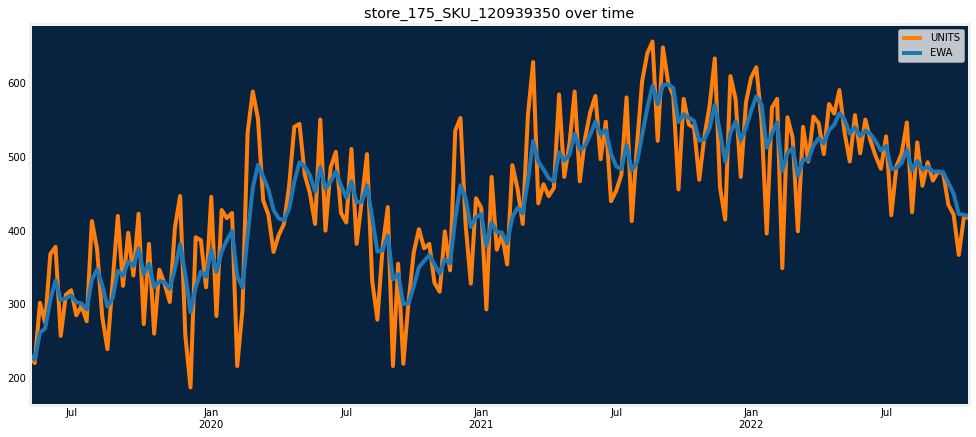

In [21]:
sid = (
    df_spikes[df_spikes["Spike"] == 1]
    .sort_values(target, ascending=False)[series_id]
    .values.tolist()[0]
)
dru.plot_series_over_time(df_spikes, date_col, series_id, sid, [target, "EWA"])

#### Negative values
Negative values should be also checked if they are correct.

In [22]:
series_neg = df_stats[df_stats["negatives"] > 0][series_id].unique().tolist()
print("# of series with negative values:", len(series_neg))
if len(series_neg) > 0:
    dru.plot_series_over_time(df, date_col, series_id, series_neg[0], [target])

# of series with negative values: 0


#### Duplicate datetimes
Duplicate datetimes within single series could be introduced by mistake.

In [23]:
series_dupl_dates = df.groupby([series_id, date_col])[date_col].count()
series_dupl_dates = series_dupl_dates[series_dupl_dates > 1]
print("# of series with duplicate dates:", len(series_dupl_dates))
if len(series_dupl_dates):
    print("eries with duplicate examples:", len(series_dupl_dates))
    print(series_dupl_dates.head())

# of series with duplicate dates: 0


#### Series start and end dates
Check if any series start after the the minimum datetime and if any series end before the maximum datetime.

In [24]:
series_new = (
    df_stats[df_stats["date_col_min"] > df_stats["date_col_min"].min()][series_id].unique().tolist()
)
series_old = (
    df_stats[df_stats["date_col_max"] < df_stats["date_col_min"].max()][series_id].unique().tolist()
)
print("# of new series:", len(series_new))
print("# of old series:", len(series_old))

# of new series: 10
# of old series: 0


#### Gaps
Completely missing records within the series should be verified.

In [25]:
df_stats.sort_values("gap_max", ascending=False).head()

,STORE_SKU,rows,date_col_min,date_col_max,target_mean,nunique,missing,zeros,negatives,gap_max,gap_mode,gap_uncommon_count,duration,rows_to_duration,missing_rate,zeros_rate
0,store_130_SKU_120931082,182,2019-05-06,2022-10-24,127.401099,95,0,0,0,7 days,7 days,0,1268,0.143533,0.0,0.000000
37,store_192_SKU_909893792,182,2019-05-06,2022-10-24,74.543956,87,0,0,0,7 days,7 days,0,1268,0.143533,0.0,0.000000
27,store_175_SKU_120949681,182,2019-05-06,2022-10-24,395.049451,136,0,0,0,7 days,7 days,0,1268,0.143533,0.0,0.000000
28,store_175_SKU_120969012,182,2019-05-06,2022-10-24,237.461538,136,0,0,0,7 days,7 days,0,1268,0.143533,0.0,0.000000
29,store_175_SKU_409929345,182,2019-05-06,2022-10-24,75.258242,96,0,1,0,7 days,7 days,0,1268,0.143533,0.0,0.005495


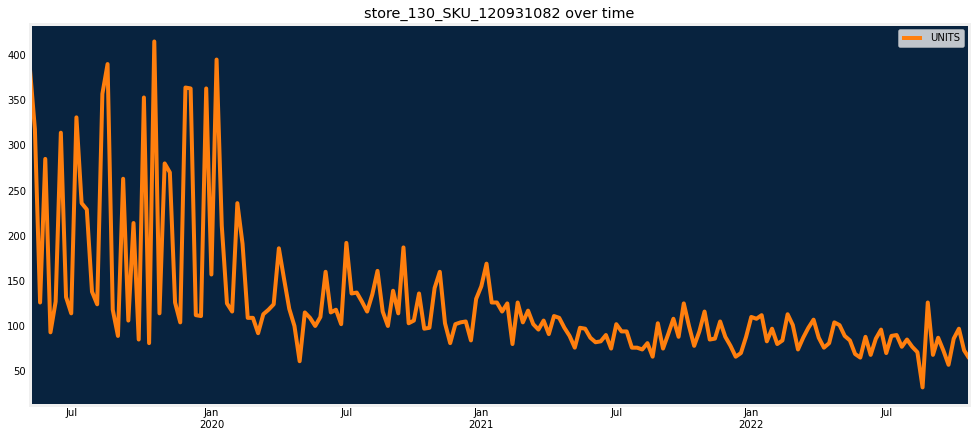

In [26]:
dru.plot_series_over_time(
    df,
    date_col,
    series_id,
    df_stats.sort_values("gap_max", ascending=False)[series_id].values[0],
    [target],
)

<a id='modeling'></a>
## Modeling

The next step after the data preparation and before modeling is [to specify the modeling parameters](https://datarobot-public-api-client.readthedocs-hosted.com/en/v2.28.0/reference/modeling/spec/time_series.html#):

- *Features known in advance* are things you know in the future, such as product metadata or a planned marketing event. If all features are known in advance, use the setting `default_to_known_in_advance`.

- *Do not derive features* will be excluded from deriving time-related features. If all features should be excluded, `default_to_do_not_derive` can be used.

- `metric` is used for evaluating models. [DataRobot supports a wide variety of metrics](https://app.datarobot.com/docs/modeling/reference/model-detail/opt-metric.html). The metric used depends on the use case. If the value is not specified, DataRobot suggests a metric based on the target distribution.

- `feature_derivation_window_start` and `feature_derivation_window_end` define the feature derivation window (FDW). The FDW represents the rolling window that is used to derive time series features and lags. FDW definition should be long enough to capture relevant trends to your use case. On the other hand, FDW shouldn't be too long (e.g., 365 days) because it shrinks the available training data and increases the size of the feature list. Older data does not help the model learn recent trends. It is not necessary to have a year-long FDW to capture seasonality; DataRobot auto-derives features (month indicator, day indicator), as well as learns effects near calendar events (if a calendar is provided), in addition to blueprint specific techniques for seasonality.

- `gap_duration` is the duration of the gap between training and validation/holdout scoring data, representing delays in data availability. For example, at prediction time, if events occuring on Monday aren't reported or made available until Wednesday, you would have a gap of 2 days. This can occur with reporting lags or with data that requires some form of validation before being stored on a system of record.

- `forecast_window_start` and `forecast_window_end` defines the forecast window (FW). It represents the rolling window of future values to predict. FW depends on a business application of the model predictions.

- `number_of_backtests` and `validation_duration`. Proper backtest configuration helps evaluate the model’s ability to generalize to the appropriate time periods. The main considerations during the backtests specification are listed below.
    - Validation from all backtests combined should span the region of interest.
    - Fewer backtests means the validation lengths might need to be longer.
    - After the specification of the appropriate validation length, the number of backtests should be adjusted until they span a full region of interest.
    - The validation duration should be at least as long as your best estimate of the amount of time the model will be in production without retraining.


- `holdout_start_date` with one of `holdout_end_date` or `holdout_duration` can be added additionally. DataRobot will define them based on `validation_duration` if they were not specified.


- `calendar_id` is the ID of the previously created calendar. DataRobot automatically create features based on the calendar events (such as “days to next event” ). There are several options to create a calendar:
    
    - From an AI Catalog dataset:
        ```python
        calendar = dr.CalendarFile.create_calendar_from_dataset(dataset_id)
        
        
        ```
    - Based on the provided country code and dataset start date and end dates:
        ```python
        calendar = dr.CalendarFile.create_calendar_from_country_code(country_code, start_date, end_date)
        
        
        ```
    - From a local file:
        ```python
        calendar = dr.CalendarFile.create(path_to_calendar_file)
        
        
        ```

- `allow_partial_history_time_series_predictions` - Not all blueprints are designed to predict on new series with only partial history, as it can lead to suboptimal predictions. This is because for those blueprints the full history is needed to derive the features for specific forecast points. "Cold start" is the ability to model on series that were not seen in the training data; partial history refers to prediction datasets with series history that is only partially known (historical rows are partially available within the feature derivation window). If `True`, Autopilot will run the blueprints optimized for cold start and also for partial history modeling, eliminating models with less accurate results for partial history support.

- `segmented_project` set to `True` and the cluster name `cluster_id` can be used for segmented modeling. This feature offers the ability to build multiple forecasting models simultaneously. DataRobot creates multiple projects “under the hood”. Each project is specific to its own data per `cluster_id`. The model benefits by having forecasts tailored to the specific data subset, rather than assuming that the important features are going to be the same across all of series. The models for different `cluster_id`s will have features engineered specifically from cluster-specific data. The benefits of segmented modeling also extend to deployments. Rather than deploying each model separately, we can deploy all of them at once within one segmented deployment.

> The function `dr.helpers.partitioning_methods.construct_duration_string()` can be used to construct a valid string representing the `gap_duration`, `validation_duration` and `holdout_duration` duration in accordance with ISO8601.

### Create a calendar

Create a calendar based on the dataset in the AI Catalog.

In [ ]:
calendar = dr.CalendarFile.create_calendar_from_dataset(
    dataset_id=dataset_calendar.id, calendar_name=dataset_calendar.name
)
calendar_id = calendar.id

### Configure modeling settings

In [ ]:
features_known_in_advance = ["STORE", "SKU", "SKU_CATEGORY", "PROMO_MAX"]
do_not_derive_features = ["STORE", "SKU", "SKU_CATEGORY"]

params = {
    "metric": None,
    "features_known_in_advance": features_known_in_advance,
    "do_not_derive_features": do_not_derive_features,
    "target": target,
    "mode": "quick",
    "segmented_project": False,
    "cluster_id": None,
    "datetime_partition_column": date_col,
    "multiseries_id_columns": [series_id],
    "use_time_series": True,
    "feature_derivation_window_start": None,
    "feature_derivation_window_end": None,
    "gap_duration": None,
    "forecast_window_start": None,
    "forecast_window_end": None,
    "number_of_backtests": None,
    "validation_duration": None,
    "calendar_id": calendar_id,
    "allow_partial_history_time_series_predictions": True,
}

### Create and run projects

Run projects using the function `dru.run_projects` and wait for completion. The arguments:

- `data` - a `dr.Dataset`, a pandas `DataFrame` or a path to a local file
- `params` - a `dictionary` with parameters as specified in the description and example above.
return a nested dictionary of `{project.id: {project meta-data : values,...}}`. Defaults to one project unless segmented modeling is enabled

In [29]:
projects = dru.run_projects(
    data=dataset_train,
    params=params,
    description="all series",
    file_to_save="projects_test.csv",
)

DataRobot will define FDW and FD automatically.
2023-01-20 18:03:33.759359 start: UNITS_20230120_1803


In [44]:
projects

{'63cb1dc57f7acc3548033664': {'project': Project(UNITS_20230120_1803),
  'project_name': 'UNITS_20230120_1803',
  'project_type': 'all series',
  'cluster_id': None,
  'cluster_name': None,
  'description': 'all series',
  'deployment_id': '63cb208ca24ba50de23d8825',
  'deployment': Deployment(UNITS_20230120_1803),
  'preds_job_def': BatchPredictionJobDefinition(63cb20f6a015dc87b07d1637),
  'preds_job_def_id': '63cb20f6a015dc87b07d1637'}}

### Initiate Autopilot

In [30]:
for cl, vals in projects.items():
    proj = vals["project"]  # DataRobot Project Object
    print(proj.id, proj)
    proj.wait_for_autopilot(verbosity=dr.enums.VERBOSITY_LEVEL.SILENT)

63cb1dc57f7acc3548033664 Project(UNITS_20230120_1803)


<a id='insights'></a>
## Model evaluation and insights

Select a project to take a closer look at model performance.

In [31]:
project = list(projects.values())[0]["project"]
if project.is_segmented:
    combined_model = project.get_combined_models()[0]
    segments_df = combined_model.get_segments_as_dataframe()
    project = dr.Project.get(
        segments_df.sort_values("row_percentage", ascending=False)["project_id"][0]
    )

print(project.id, project)

63cb1dc57f7acc3548033664 Project(UNITS_20230120_1803)


### Retrieve models

Select the most accurate model from the Leaderboard.

In [32]:
model_scores = dru.get_leaderboard(project)
model = model_scores["model"][0]
print(model.id, model)
model_scores.head()

63cb1e6e40ff7079faba3407 DatetimeModel('eXtreme Gradient Boosting Regressor with Early Stopping and New Series Support')


,project_id,blueprint_id,featurelist_id,model_id,model_n,model_cat,model_type,model,duration,end_date,RMSE_backtests,RMSE_backtest1
0,63cb1dc57f7acc3548033664,10807011a661cff2077ffcae75a240f5,63cb1e317157b7ddd0784314,63cb1e6e40ff7079faba3407,15,model,eXtreme Gradient Boosting Regressor with Early...,DatetimeModel('eXtreme Gradient Boosting Regre...,P0Y0M797D,NaT,43.79093,34.57502
1,63cb1dc57f7acc3548033664,10807011a661cff2077ffcae75a240f5,63cb1f40eb25b482359d0195,63cb1f41eb25b482359d019c,36,model,eXtreme Gradient Boosting Regressor with Early...,DatetimeModel('eXtreme Gradient Boosting Regre...,P0Y0M797D,NaT,43.82645,34.24454
2,63cb1dc57f7acc3548033664,919fd7caa918c51626dcdcbf3e4a2fe5,63cb1e317157b7ddd0784314,63cb1e6e40ff7079faba3406,14,model,eXtreme Gradient Boosting Regressor with Early...,DatetimeModel('eXtreme Gradient Boosting Regre...,P0Y0M797D,NaT,44.04191,32.92600
3,63cb1dc57f7acc3548033664,f7b1dd1f2967237ac8aec1510e1a2c48,63cb1e317157b7ddd0784314,63cb1e6e40ff7079faba3403,11,model,Performance Clustered eXtreme Gradient Boosted...,DatetimeModel('Performance Clustered eXtreme G...,P0Y0M797D,NaT,44.92713,34.66657
4,63cb1dc57f7acc3548033664,586e48c7da793c3384aa5102caaef2e5,63cb1e317157b7ddd0784314,63cb1e6e40ff7079faba3404,12,model,Temporal Hierarchical Model with Elastic Net a...,DatetimeModel('Temporal Hierarchical Model wit...,P0Y0M797D,NaT,45.56763,34.62065


### Accuracy over time

[Accuracy over time](https://app.datarobot.com/docs/modeling/analyze-models/evaluate/aot.html) helps visualize how predictions change over time compared to actuals.

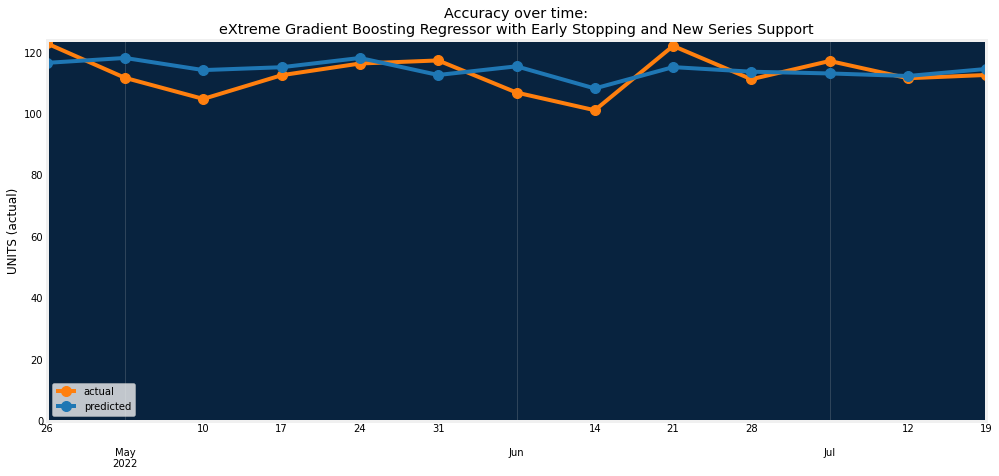

In [33]:
dru.plot_accuracy_over_time(project, model)

### Stability

View an [at-a-glance summary](https://app.datarobot.com/docs/modeling/analyze-models/evaluate/stability.html) of how well a model performs on different backtests.

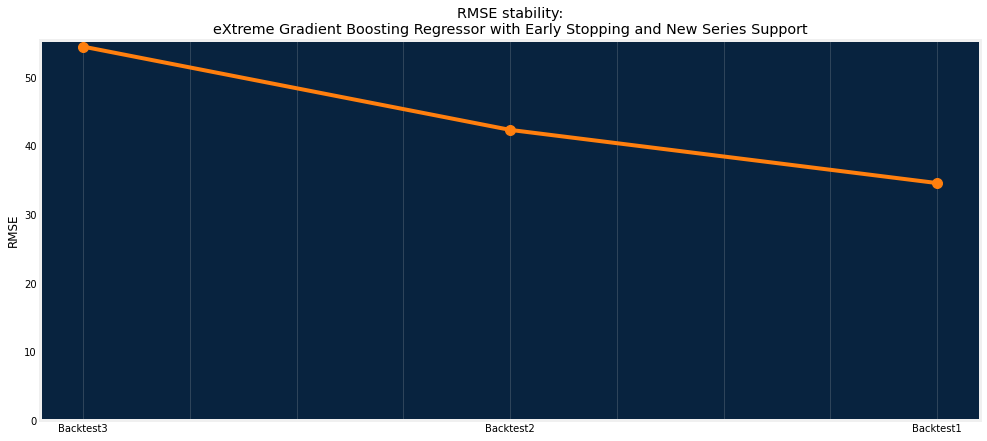

In [34]:
dru.plot_stability_scores(project, model)

### Series insights

[Series insights](https://app.datarobot.com/docs/modeling/analyze-models/evaluate/series-acc.html) provide data representing accuracy, average scores, length, and start/end date distribution by count for each series.

In [35]:
model_sa = dru.get_series_accuracy(project, model, compute_all_series=True)
print("project metric:", project.metric)
print(model_sa.shape)
model_sa.head()

project metric: RMSE
(50, 10)


,multiseriesId,multiseriesValues,rowCount,duration,startDate,endDate,validationScore,backtestingScore,holdoutScore,targetAverage
0,63cb1df7f8f3aac9f4cba3ce,[store_130_SKU_120931082],182,P3Y5M18D,2019-05-06T00:00:00.000000Z,2022-10-24T00:00:00.000000Z,11.47039,17.603000,22.04872,127.401099
1,63cb1df7f8f3aac9f4cba3cf,[store_130_SKU_120969795],182,P3Y5M18D,2019-05-06T00:00:00.000000Z,2022-10-24T00:00:00.000000Z,17.91493,21.465530,21.05725,46.098901
2,63cb1df7f8f3aac9f4cba3d0,[store_133_SKU_9888998],182,P3Y5M18D,2019-05-06T00:00:00.000000Z,2022-10-24T00:00:00.000000Z,19.46449,14.697310,22.61437,46.986264
3,63cb1df7f8f3aac9f4cba3d1,[store_136_SKU_120973845],182,P3Y5M18D,2019-05-06T00:00:00.000000Z,2022-10-24T00:00:00.000000Z,18.62200,20.046770,23.13299,88.274725
4,63cb1df7f8f3aac9f4cba3d2,[store_137_SKU_120949681],182,P3Y5M18D,2019-05-06T00:00:00.000000Z,2022-10-24T00:00:00.000000Z,30.88644,105.254205,62.46387,232.565934


### Feature Impact

[Feature Impact](https://app.datarobot.com/docs/modeling/analyze-models/understand/feature-impact.html) is available for all model types and works by altering input data and observing the effect on a model’s score. It is an on-demand feature, meaning that you must initiate a calculation to see the results. Once you have had DataRobot compute the feature impact for a model, that information is saved with the project.

Feature Impact measures how important a feature is in the context of a model. That is, it measures how much the accuracy of a model would decrease if that feature were removed.

Note that the diversity of features created is providing signal to the model. 

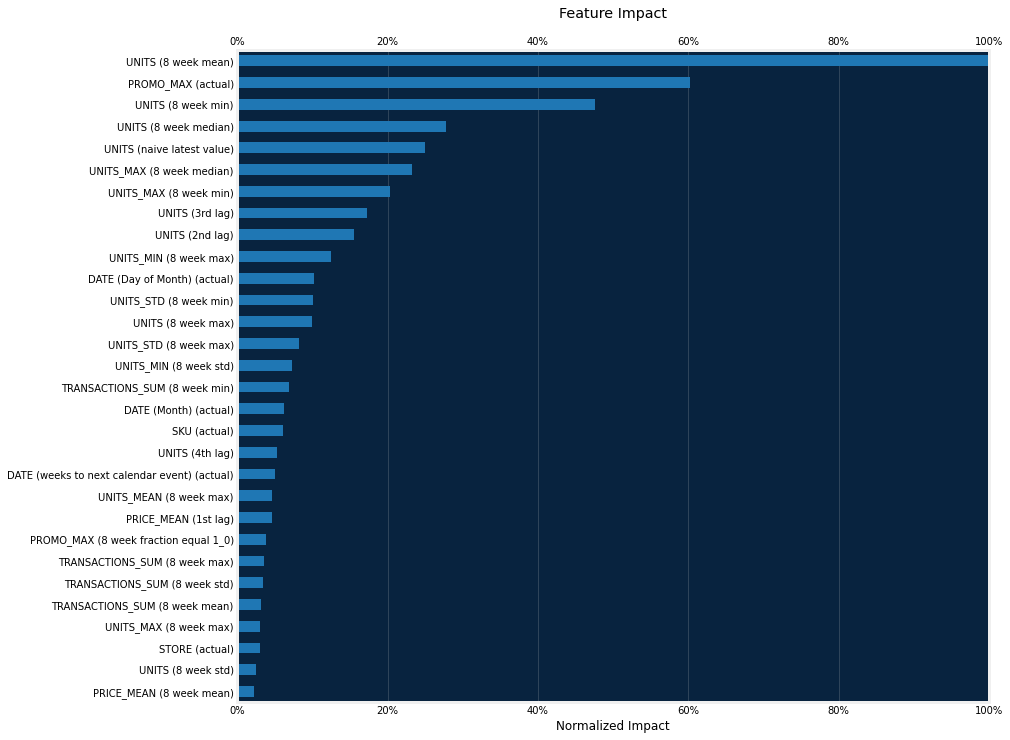

In [36]:
dru.plot_feature_impacts(model, top_n=30)

<a id='deployment'></a>
## Deployment

After you have selected your final model, you have multiple options for a production deployment in DataRobot MLOps. Creating a deployment will add your model package to the Model Registry and containerize all model artifacts, generate compliance documentation, expose a production quality REST API on a prediction server in your DataRobot cluster, and enable all lifecycle management fucntionality, like drift monitoring. Two helper function are provided below:

`dru.make_deployments` accepts a dictionary of projects and deploys the DataRobot recommended model. This will enable multiple deployments if you are using segmented modeling, which can be helpful if you have many segments (and thus many models to deploy). 

`dru.make_deployment` can be used to deploy a specific model by passing the `model.id`. If `model.id` is **None**, the DataRobot recommended model from the project will be deployed.

In [37]:
deployments = dru.make_deployments(
    projects, file_to_save="deployments_test.csv", feature_drift_enabled=True
)

Deployment ID: 63cb208ca24ba50de23d8825; URL: https://app.datarobot.com/deployments/63cb208ca24ba50de23d8825/overview



In [46]:
dep2 = dru.make_deployment(
    project=project,
    name="Temporal Hierarchical Model with Elastic Net and XGBoost",
    model_id="63cb1e6e40ff7079faba3404",
)

Deployment ID: 63cb51522fe7840c4fa43cfd; URL: https://app.datarobot.com/deployments/63cb51522fe7840c4fa43cfd/overview



<a id='preds'></a>
## Make predictions

The scoring dataset should follow requirements to ensure the Batch Prediction API can make predictions: 
- Sort prediction rows by their series ID then timestamp, with the earliest row first.
- The dataset must contain rows without a target for the desired forecast window.

You can find more details on the scoring dataset structure [in the DataRobot documentation](https://app.datarobot.com/docs/api/reference/batch-prediction-api/batch-pred-ts.html#requirements-for-the-scoring-dataset).

### Batch predictions on demand

Select the data from your data store, make predictions, and write them back to Snowflake once processed,.

In [38]:
intake_settings = {
    "type": "jdbc",
    "data_store_id": data_store_id,
    "credential_id": credential_id,
    "query": f'select * from {db}.{schema}."ts_demand_forecasting_scoring" order by {series_id}, {date_col};',
}

output_settings = {
    "type": "jdbc",
    "data_store_id": data_store_id,
    "credential_id": credential_id,
    "table": "ts_demand_forecasting_predictions",
    "schema": schema,
    "catalog": db,
    "create_table_if_not_exists": True,
    "statement_type": "insert",
}

pred_jobs = dru.make_predictions(
    deployments=deployments,
    intake_settings=intake_settings,
    output_settings=output_settings,
    passthrough_columns_set=None,
    passthrough_columns=["SKU", "STORE"],
)

2023-01-20 18:16:21.003062 start: UNITS_20230120_1803 predictions


### Scheduled batch predictions

Use prediction job definitions to make batch predictions on a schedule.

In [39]:
intake_settings = {
    "type": "jdbc",
    "data_store_id": data_store_id,
    "credential_id": credential_id,
    "query": f'select * from {db}.{schema}."ts_demand_forecasting_scoring" order by {series_id}, {date_col};',
}

output_settings = {
    "type": "jdbc",
    "data_store_id": data_store_id,
    "credential_id": credential_id,
    "table": "ts_demand_forecasting_predictions",
    "schema": schema,
    "catalog": db,
    "create_table_if_not_exists": True,
    "statement_type": "insert",
}

schedule = {
    "minute": [0],
    "hour": [23],
    "day_of_week": ["*"],
    "day_of_month": ["*"],
    "month": ["*"],
}

deployments = dru.create_preds_job_definitions(
    deployments=deployments,
    intake_settings=intake_settings,
    output_settings=output_settings,
    enabled=False,
    schedule=schedule,
    passthrough_columns_set=None,
    passthrough_columns=["SKU", "STORE"],
)

2023-01-20 18:17:09.453436 start: UNITS_20230120_1803 create predictions job definition


In [40]:
# # Run predictions job definitions manually

# for pid, vals in deployments.items():
#     vals['preds_job_def'].run_once()

## Get predictions

In the previous step, you ran prediction jobs from your registered data store (Snowflake) with your prediciton dataset, `ts_demand_forecasting_scoring` . The steps below add the new prediction table, `ts_demand_forecasting_predictions`, to the AI Catalog. This enables versioning of each prediciton run, and completing the governance loop for traceability from scoring data to model to predicition data.


In [41]:
# Create or get an existing data connection based on a query and upload the predictions into AI Catalog

data_source_preds, dataset_preds = dru.create_dataset_from_data_source(
    data_source_name="ts_preds_data",
    query=f'select * from {db}.{schema}."ts_demand_forecasting_predictions";',
    data_store_id=data_store_id,
    credential_id=credential_id,
)

new data source: DataSource('ts_preds_data')


The table with predictions has the following schema:
- `{SERIES_ID_COLUMN_NAME}` is the series ID the row belongs to. In this demo the column name is STORE_SKU.
- `FORECAST_POINT` is the timestamp ou are making a prediction from.
- `{TIME_COLUMN_NAME}` is the time series timestamp the predictions were made for. In this demo the column name is DATE.
- `FORECAST_DISTANCE` is a unique relative position within the Forecast Window. A model outputs one row for each Forecast Distance.
- `<target_name>_PREDICTION`
- `DEPLOYMENT_APPROVAL_STATUS`. If the approval workflow is enabled for the deployment, the output schema will contain an extra column showing the deployment approval status.
- Other columns specified in `passthrough_columns` or all columns from the prediction dataset if `passthrough_columns_set='all'`.

You can find more details on the predictions structure [in the DataRobot documentation](https://app.datarobot.com/docs/api/reference/batch-prediction-api/output-format.html#time-series-models). 

In [42]:
# Get predictions as a dataframe

df_preds = dataset_preds.get_as_dataframe()
df_preds[date_col] = pd.to_datetime(df_preds[date_col], format="%Y-%m-%d")
df_preds.sort_values([series_id, date_col], inplace=True)
print("the original data shape   :", df_preds.shape)
print("the total number of series:", df_preds[series_id].nunique())
print("the min date:", df_preds[date_col].min())
print("the max date:", df_preds[date_col].max())
df_preds.head()

the original data shape   : (200, 8)
the total number of series: 50
the min date: 2022-10-30 17:00:00
the max date: 2022-11-20 16:00:00


,STORE_SKU,FORECAST_POINT,DATE,FORECAST_DISTANCE,UNITS (actual)_PREDICTION,DEPLOYMENT_APPROVAL_STATUS,SKU,STORE
0,store_130_SKU_120931082,2022-10-23 17:00:00.000,2022-10-30 17:00:00,1.0,77.779026,APPROVED,SKU_120931082,store_130
199,store_130_SKU_120931082,2022-10-23 17:00:00.000,2022-11-06 16:00:00,2.0,78.455166,APPROVED,SKU_120931082,store_130
198,store_130_SKU_120931082,2022-10-23 17:00:00.000,2022-11-13 16:00:00,3.0,80.292369,APPROVED,SKU_120931082,store_130
197,store_130_SKU_120931082,2022-10-23 17:00:00.000,2022-11-20 16:00:00,4.0,89.633220,APPROVED,SKU_120931082,store_130
196,store_130_SKU_120969795,2022-10-23 17:00:00.000,2022-10-30 17:00:00,1.0,66.912723,APPROVED,SKU_120969795,store_130


## Conclusion

This notebook's workflow provides a repeatable framework from project setup to model deployment for times series data with multiple series (SKUs) with full, partial and no history.  This notebook presented frameworks for aggregation at the SKU and store-SKU level, and provided functions to streamline building and deploying multiple models from time series projects with and without Segmented Modeling enabled. It also provided helpers to extract series and model insights for common challenges seen in real-world data, and multiple methods for prediciton and production deployment with full MLOps capabilities. The steps above provide many of the building blocks necessary for evaluating and experimenting on complex, real-world multi-series data.

An extremely common practice in the field is running experiments with various feature derivation windows and forecast distances. For example, if a business desires predictions 6 months out, and you have a few years of history, the best model to predict 3-6 months out may not be the same model that best predicts 1-3 months out. Conceptually, recall that DataRobot generates a wide range of lagged features based on the Feature Derivation Window. The features that best capture short-term predictions (with customer data, this can be lags of a few days or weeks and product interactions), can quite reasonably not be the same set of features that capture mid to long-term predictions.  This can be compounded when you have a large number of series/SKUs; many blueprints are designed to learn interactions and trends across series, which again can have different interaction effects and periodicities. This is usually a good indicator to use Segmented Modeling.  At the same time, one model could work quite well depending on the dynamics of your target.  There is no silver bullet, hence the benefit of learning how to apply automation to rapidly experiment and improve your models.

In all cases, ensuring your validation period captures the behavior you want to predict, and that your backtests do as well, is vitally important. 

Try experimenting with differnet Forecast Distances and compare the important features across projects.  Enable the various project settings in the `params` dictionary in the **Run Projects** section, and enable Segmented Modeling. Identify and evaluate the peformance of some of the partial history series. Getting comfortable with these common workflows will accelerate your time to value in future projects. 

## Delete project artifacts 

Optional.

In [43]:
# # Uncomment and run this cell to remove everything you added in DataRobot during this session

# dr.Dataset.delete(dataset_train.id)
# dr.Dataset.delete(dataset_calendar.id)
# dr.Dataset.delete(dataset_preds.id)

# data_source_train.delete()
# data_source_calendar.delete()
# data_source_preds.delete()

# _ = [d['preds_job_def'].delete() for d in list(deployments.values())]

# _ = [d['deployment'].delete() for d in list(deployments.values())]

# _ = [p['project'].delete() for p in list(projects.values())]

# dr.CalendarFile.delete(calendar_id)